# reference : https://www.kaggle.com/code/ammarnassanalhajali/layout-parser-model-training

In [1]:
!nvidia-smi


Thu Jan 26 01:48:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:65:00.0 Off |                  Off |
| 30%   45C    P8    31W / 300W |   5943MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.listdir('./')

['test-coco.json',
 'badlad_dataset',
 'train-coco.json',
 'output',
 '.ipynb_checkpoints',
 'detectron2',
 'Bangla_DLA_trainer.ipynb',
 'BadLad_maskrcnn_trainer.ipynb',
 'coco-test.json',
 'BadLad_trainer_faster_rcnn.ipynb',
 'train_badlad.py',
 'badlad_trained']

In [3]:
os.listdir('./badlad_dataset/')

['BDLAD_08',
 'BDLAD_07',
 'BDLAD_train_coco.json',
 'BDLAD_02',
 'BDLAD_01',
 'BDLAD_12',
 'BDLAD_test_coco.json',
 'BDLAD.json',
 'BDLAD_10',
 'BDLAD_09',
 'layoutparserweights',
 'all_imgs',
 'BDLAD_06',
 'BDLAD_11',
 'BDLAD_03',
 'BDLAD_04',
 'BDLAD_05']

In [4]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
import torch, torchvision,numpy
print(torch.__version__, torch.cuda.is_available(),numpy.__version__) #1.13.1 True 1.23.5


1.10.0 True 1.23.5


# install detectron2

In [6]:
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# imports

In [7]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
#from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional


# torch
import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
# import numba
# from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import shutil
setup_logger()

<Logger detectron2 (DEBUG)>

In [8]:
train = True

debug= False #if False,train on full dataset otherwise use only 200 samples for training
pretrained = False #if true,then finetune using pretrained weights,otherwise train from scratch


imgdir="/home/ansary/Downloads/BadLad/badlad_dataset/all_imgs/"
train_coco = "/home/ansary/Downloads/BadLad/badlad_dataset/BDLAD_train_coco.json"
test_coco = "/home/ansary/Downloads/BadLad/badlad_dataset/BDLAD_test_coco.json"

if(train):
    if os.path.exists('./output'):
        print("removing  -> ",'./output')
        shutil.rmtree('./output')


removing  ->  ./output


Reference -> https://www.kaggle.com/code/ammarnassanalhajali/layout-parser-model-training

# load coco annotations

In [9]:
f = open(train_coco)
feval = open(test_coco)
thing_classes  = []
thing_classes_id = {}
data_annotations=[]

thing_classes_val  = []
thing_classes_id_val = {}
data_annotations_val=[]

data = json.load(f)
data_val = json.load(feval)

#----Images----
data_images=data['images']
data_images_val=data_val['images']

#---annotations train-
for i in data['annotations']:
    annot_obj ={"id": i['id'],"gt_masks":i['segmentation'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+height
         }
    data_annotations.append(annot_obj) 

#---annotations eval-
for i in data_val['annotations']:
    annot_obj_eval ={"id": i['id'],"gt_masks":i['segmentation'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+height
         }
    data_annotations_val.append(annot_obj_eval) 
    
    
#---categories train-
for i in data['categories']:
    thing_classes.append(i['name'])
    thing_classes_id[i['name']]=i['id']
f.close()

#---categories eval-
for i in data_val['categories']:
    thing_classes_val.append(i['name'])
    thing_classes_id_val[i['name']]=i['id']
feval.close()

print("thing_classes=",thing_classes)
print("thing_classes_id=",thing_classes_id)

print("thing_classes_val=",thing_classes_val)
print("thing_classes_id_val=",thing_classes_id_val)

thing_classes= ['paragraph', 'text_box', 'image', 'table']
thing_classes_id= {'paragraph': 0, 'text_box': 1, 'image': 2, 'table': 3}
thing_classes_val= ['paragraph', 'text_box', 'image', 'table']
thing_classes_id_val= {'paragraph': 0, 'text_box': 1, 'image': 2, 'table': 3}


In [10]:
# thing_classes= ['None','paragraph', 'text_box', 'image', 'table']
thing_classes= ['paragraph', 'text_box', 'image', 'table']

In [11]:
train_meta = pd.DataFrame(data_images)
train_meta = train_meta[['id', 'file_name', 'width', 'height']]
train_meta = train_meta.rename(columns={"id":"image_id"})
print("train_meta size=",len(train_meta))
train_meta.head(3)

train_meta size= 20367


,image_id,file_name,width,height
0,0,a4c953a8-70a9-4f9e-9c15-b82fcf0be537.png,720,995
1,1,554a63fb-1749-4a8a-84bc-3ed8a9724e04.png,1700,2800
2,2,ecdbeed5-b8ed-44bf-b23e-762debc8a79e.png,1700,2800


In [12]:
val_meta = pd.DataFrame(data_images_val)
val_meta = val_meta[['id', 'file_name', 'width', 'height']]
val_meta = val_meta.rename(columns={"id":"image_id"})
print("val_meta size=",len(val_meta))
val_meta.head(3)

val_meta size= 13328


,image_id,file_name,width,height
0,0,7755260c-42cf-48d1-9a79-0ffc154d9b63.png,3531,4995
1,1,e158046e-43d8-47eb-a9f1-3db7653764ac.png,1653,2339
2,2,4a47c322-eecd-4594-916c-50b0eddfcc0d.png,1653,2339


In [13]:
train_df = pd.DataFrame(data_annotations)
print("train_df size=",len(train_df))
train_df.head(3)

train_df size= 425109


,id,gt_masks,image_id,category_id,x_min,y_min,x_max,y_max
0,0,"[[86.328, 179.007, 657.662, 183.008, 654.662, ...",0,0,56.0,179.0,657.0,277.0
1,1,"[[102.995, 281.675, 657.328, 281.675, 652.995,...",0,0,54.0,281.0,657.0,378.0
2,2,"[[509.995, 539.345, 602.328, 543.012, 599.662,...",0,2,509.0,539.0,666.0,585.0


In [14]:
val_df = pd.DataFrame(data_annotations_val)
print("val_df size=",len(val_df))
val_df.head(3)

val_df size= 285139


,id,gt_masks,image_id,category_id,x_min,y_min,x_max,y_max
0,0,"[[1672.592, 2509.367, 2923.195, 2490.089, 2923...",0,0,744.0,2490.0,2923.0,2721.0
1,1,"[[266.465, 437.095, 802.465, 69.091, 3226.465,...",0,2,266.0,69.0,3226.0,1329.0
2,2,"[[2451.155, 1616.834, 2695.983, 1558.212, 2858...",0,2,2451.0,1558.0,2892.0,1861.0


In [15]:

split_mode="all_train" # all_train Or  valid20 
# image_Width=768
# image_Height=768


if debug:
    train_meta = train_meta.iloc[:200]  # For debug...
    val_meta = val_meta.iloc[:100]
len(train_meta),len(val_meta)

(20367, 13328)

# prepare and register data for detectron2

In [16]:
def get_PL_data_dicts(
    imgdir: Path,
    _train_df: pd.DataFrame,
    _train_meta: pd.DataFrame,
    use_cache: bool = True,
    target_indices: Optional[np.ndarray] = None,
    debug: bool = False,
    data_type:str="train"
   
):
    
    dataset_dicts = []
    for index, train_meta_row in tqdm(_train_meta.iterrows(), total=len(_train_meta)):
                    record = {}
                    image_id,file_name, width,height = train_meta_row.values
                    filename = str(f'{imgdir}/{file_name}')
                    record["file_name"] = filename
                    record["image_id"] = image_id
                    record["width"] = width
                    record["height"] = height
                    objs = []
                    for index2, row in _train_df.query("image_id == @image_id").iterrows():
                        class_id = row["category_id"]
                        gt_masks = row["gt_masks"]
                        bbox_resized = [
                            float(row["x_min"]),
                            float(row["y_min"]),
                            float(row["x_max"]),
                            float(row["y_max"]),
                        ]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "segmentation": gt_masks,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    record["annotations"] = objs
                    dataset_dicts.append(record)
                    
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

In [17]:
%%time

Data_Resister_training="PL_data_train";
Data_Resister_valid="PL_data_valid";

if split_mode == "all_train":
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)
    #eval
    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            val_df,
            val_meta,
            debug=debug,
            data_type="val"
        ),
    )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    
    
    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)
    
    
    
    
elif split_mode == "valid20":

    n_dataset = len(train_meta)
    n_train = int(n_dataset * 0.90)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(12)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=train_inds,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=valid_inds,
            debug=debug,
            data_type="val"
            ),
        )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

  0%|          | 0/20367 [00:00<?, ?it/s]

  0%|          | 0/13328 [00:00<?, ?it/s]

CPU times: user 1min 34s, sys: 445 ms, total: 1min 34s
Wall time: 1min 33s


In [18]:
print("dicts training size=",len(dataset_dicts_train),"################  dicts valid size=",len(dataset_dicts_valid))

#print("dicts training size=",len(dataset_dicts_train))

dicts training size= 20367 ################  dicts valid size= 13328


In [19]:
dataset_dicts_train[5]

{'file_name': '/home/ansary/Downloads/BadLad/badlad_dataset/all_imgs//9f89a373-ca23-4a29-8fce-55a474dbde21.png',
 'image_id': 5,
 'width': 1202,
 'height': 1645,
 'annotations': [{'bbox': [122.0, 311.0, 1121.0, 422.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[131.587,
     311.739,
     1121.587,
     323.739,
     1100.587,
     422.739,
     649.587,
     419.739,
     220.587,
     416.739,
     122.587,
     378.739]],
   'category_id': 0},
  {'bbox': [113.0, 405.0, 1011.0, 474.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[138.587,
     405.739,
     1011.587,
     416.739,
     1003.587,
     473.739,
     113.587,
     474.739]],
   'category_id': 0},
  {'bbox': [131.0, 479.0, 1116.0, 555.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'segmentation': [[145.587,
     479.739,
     1094.587,
     479.739,
     1116.587,
     513.739,
     552.587,
     555.739,
     131.587,
     555.739]],
   'category_id': 0},
  {'bbox': [233.0, 34.0, 495.0, 26

# Augmentation

In [20]:
def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Train

In [21]:
%%time
print("training........")
cfg = get_cfg()
# config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 

config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" 

cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)

if split_mode == "all_train":
#     cfg.DATASETS.TEST = ()
    cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000
else:
    cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000

cfg.DATALOADER.NUM_WORKERS = 8
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
if(pretrained):
    print("pretrained")
    cfg.MODEL.WEIGHTS="./badlad_dataset/layoutparserweights/PubLayNet_faster_rcnn_R_50_FPN_3x/PubLayNet_faster_rcnn_R_50_FPN_3x/model_final.pth"

cfg.SOLVER.AMP.ENABLED = True
cfg.SOLVER.IMS_PER_BATCH = 48
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 5
cfg.SOLVER.MAX_ITER = 10000 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (500, 1000) # must be less than  MAX_ITER 
cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4


print("creating cfg.OUTPUT_DIR -> ",cfg.OUTPUT_DIR)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
# trainer = AugTrainer(cfg) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
if(train):
    trainer.train()

training........
creating cfg.OUTPUT_DIR ->  ./output
[01/26 01:50:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(nu

  0%|          | 0/20367 [00:00<?, ?it/s]

[01/26 01:51:39 d2.data.build]: Removed 0 images with no usable annotations. 20367 images left.
[01/26 01:51:40 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 209588       |  text_box  | 203869       |   image    | 10297        |
|   table    | 1355         |            |              |            |              |
|   total    | 425109       |            |              |            |              |
[01/26 01:51:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/26 01:51:40 d2.data.build]: Using training sampler TrainingSampler
[01/26 01:51:40 d2.data.common]: Serializing 20367 elements to byte tensors and concatenating them all ...
[0

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

[01/26 01:51:41 d2.engine.train_loop]: Starting training from iteration 0
[01/26 01:52:48 d2.utils.events]:  eta: 9:00:29  iter: 19  total_loss: 2.468  loss_cls: 0.7458  loss_box_reg: 0.1731  loss_mask: 0.5046  loss_rpn_cls: 0.6046  loss_rpn_loc: 0.4179  time: 3.2879  data_time: 1.3934  lr: 0.001  max_mem: 24462M
[01/26 01:53:57 d2.utils.events]:  eta: 9:00:08  iter: 39  total_loss: 1.952  loss_cls: 0.4773  loss_box_reg: 0.3004  loss_mask: 0.4552  loss_rpn_cls: 0.3574  loss_rpn_loc: 0.3408  time: 3.3497  data_time: 1.3532  lr: 0.001  max_mem: 24462M
[01/26 01:55:09 d2.utils.events]:  eta: 9:13:45  iter: 59  total_loss: 1.934  loss_cls: 0.4202  loss_box_reg: 0.4755  loss_mask: 0.4586  loss_rpn_cls: 0.2349  loss_rpn_loc: 0.3256  time: 3.4485  data_time: 1.5826  lr: 0.001  max_mem: 24462M
[01/26 01:56:25 d2.utils.events]:  eta: 9:18:20  iter: 79  total_loss: 1.964  loss_cls: 0.4117  loss_box_reg: 0.5992  loss_mask: 0.4603  loss_rpn_cls: 0.1741  loss_rpn_loc: 0.3153  time: 3.5335  data_tim

[01/26 02:34:57 d2.utils.events]:  eta: 9:35:06  iter: 699  total_loss: 1.457  loss_cls: 0.3288  loss_box_reg: 0.5219  loss_mask: 0.3108  loss_rpn_cls: 0.06262  loss_rpn_loc: 0.2141  time: 3.7073  data_time: 1.3755  lr: 0.001  max_mem: 24462M
[01/26 02:36:09 d2.utils.events]:  eta: 9:32:30  iter: 719  total_loss: 1.452  loss_cls: 0.3314  loss_box_reg: 0.517  loss_mask: 0.3056  loss_rpn_cls: 0.07125  loss_rpn_loc: 0.2352  time: 3.7038  data_time: 1.4249  lr: 0.001  max_mem: 24462M
[01/26 02:37:22 d2.utils.events]:  eta: 9:31:27  iter: 739  total_loss: 1.436  loss_cls: 0.3296  loss_box_reg: 0.5123  loss_mask: 0.3022  loss_rpn_cls: 0.06633  loss_rpn_loc: 0.2291  time: 3.7022  data_time: 1.5403  lr: 0.001  max_mem: 24462M
[01/26 02:38:39 d2.utils.events]:  eta: 9:30:32  iter: 759  total_loss: 1.42  loss_cls: 0.3234  loss_box_reg: 0.5065  loss_mask: 0.3012  loss_rpn_cls: 0.06655  loss_rpn_loc: 0.2161  time: 3.7066  data_time: 1.7550  lr: 0.001  max_mem: 24462M
[01/26 02:39:54 d2.utils.event

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 02:54:07 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 136331       |  text_box  | 140380       |   image    | 7452         |
|   table    | 976          |            |              |            |              |
|   total    | 285139       |            |              |            |              |
[01/26 02:54:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 02:54:07 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 02:54:07 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 02:54:07 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evalu

[01/26 03:31:10 d2.utils.events]:  eta: 8:36:35  iter: 1599  total_loss: 1.281  loss_cls: 0.2788  loss_box_reg: 0.474  loss_mask: 0.2786  loss_rpn_cls: 0.0535  loss_rpn_loc: 0.1955  time: 3.7067  data_time: 1.4510  lr: 0.001  max_mem: 24462M
[01/26 03:32:24 d2.utils.events]:  eta: 8:35:38  iter: 1619  total_loss: 1.262  loss_cls: 0.2792  loss_box_reg: 0.464  loss_mask: 0.2749  loss_rpn_cls: 0.05256  loss_rpn_loc: 0.1907  time: 3.7065  data_time: 1.5902  lr: 0.001  max_mem: 24462M
[01/26 03:33:39 d2.utils.events]:  eta: 8:34:24  iter: 1639  total_loss: 1.277  loss_cls: 0.2886  loss_box_reg: 0.4611  loss_mask: 0.275  loss_rpn_cls: 0.05058  loss_rpn_loc: 0.2063  time: 3.7071  data_time: 1.6658  lr: 0.001  max_mem: 24462M
[01/26 03:34:52 d2.utils.events]:  eta: 8:33:22  iter: 1659  total_loss: 1.246  loss_cls: 0.2753  loss_box_reg: 0.4519  loss_mask: 0.2693  loss_rpn_cls: 0.04946  loss_rpn_loc: 0.1948  time: 3.7066  data_time: 1.5719  lr: 0.001  max_mem: 24462M
[01/26 03:36:05 d2.utils.eve

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 03:56:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 03:56:20 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 03:56:20 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 03:56:20 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 03:56:20 d2.utils.events]:  eta: 8:11:28  iter: 1999  total_loss: 1.217  loss_cls: 0.2653  loss_box_reg: 0.4394  loss_mask: 0.2647  loss_rpn_cls: 0.04506  loss_rpn_loc: 0.1858  time: 3.7024  data_time: 1.6128  lr: 0.001  max_mem: 24462M
[01/26 03:57:30 d2.utils.events]:  eta: 8:10:14  iter: 2019  total_loss: 1.233  loss_cls: 0.2772  loss_box_reg: 0.4515  loss_mask: 0.2675  loss_rpn_cls: 0.04569  loss_rpn_loc: 0.1867  time: 3.7000  data_time: 1.3789  lr: 0.001  max_mem: 24462M
[01/26 03:

[01/26 04:35:05 d2.utils.events]:  eta: 7:28:21  iter: 2639  total_loss: 1.203  loss_cls: 0.2724  loss_box_reg: 0.4422  loss_mask: 0.2605  loss_rpn_cls: 0.04616  loss_rpn_loc: 0.1825  time: 3.6853  data_time: 1.4346  lr: 0.001  max_mem: 24462M
[01/26 04:36:17 d2.utils.events]:  eta: 7:27:18  iter: 2659  total_loss: 1.129  loss_cls: 0.2547  loss_box_reg: 0.4188  loss_mask: 0.2529  loss_rpn_cls: 0.04195  loss_rpn_loc: 0.1802  time: 3.6844  data_time: 1.4583  lr: 0.001  max_mem: 24462M
[01/26 04:37:30 d2.utils.events]:  eta: 7:26:18  iter: 2679  total_loss: 1.17  loss_cls: 0.2675  loss_box_reg: 0.4243  loss_mask: 0.2571  loss_rpn_cls: 0.04207  loss_rpn_loc: 0.1856  time: 3.6843  data_time: 1.5924  lr: 0.001  max_mem: 24462M
[01/26 04:38:39 d2.utils.events]:  eta: 7:23:59  iter: 2699  total_loss: 1.175  loss_cls: 0.2594  loss_box_reg: 0.4286  loss_mask: 0.256  loss_rpn_cls: 0.04764  loss_rpn_loc: 0.1869  time: 3.6826  data_time: 1.3690  lr: 0.001  max_mem: 24462M
[01/26 04:39:50 d2.utils.e

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 04:57:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 04:57:29 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 04:57:30 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 04:57:30 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 04:57:30 d2.utils.events]:  eta: 7:04:38  iter: 2999  total_loss: 1.175  loss_cls: 0.2684  loss_box_reg: 0.425  loss_mask: 0.2547  loss_rpn_cls: 0.04354  loss_rpn_loc: 0.1828  time: 3.6794  data_time: 1.5745  lr: 0.001  max_mem: 24462M
[01/26 04:58:42 d2.utils.events]:  eta: 7:03:25  iter: 3019  total_loss: 1.189  loss_cls: 0.2645  loss_box_reg: 0.4309  loss_mask: 0.2554  loss_rpn_cls: 0.04487  loss_rpn_loc: 0.1817  time: 3.6788  data_time: 1.4973  lr: 0.001  max_mem: 24462M
[01/26 04:5

[01/26 05:36:32 d2.utils.events]:  eta: 6:24:46  iter: 3639  total_loss: 1.122  loss_cls: 0.2536  loss_box_reg: 0.4124  loss_mask: 0.249  loss_rpn_cls: 0.0405  loss_rpn_loc: 0.1745  time: 3.6759  data_time: 1.5713  lr: 0.001  max_mem: 24462M
[01/26 05:37:38 d2.utils.events]:  eta: 6:23:02  iter: 3659  total_loss: 1.14  loss_cls: 0.2498  loss_box_reg: 0.4149  loss_mask: 0.2501  loss_rpn_cls: 0.0398  loss_rpn_loc: 0.177  time: 3.6738  data_time: 1.2077  lr: 0.001  max_mem: 24462M
[01/26 05:38:51 d2.utils.events]:  eta: 6:21:18  iter: 3679  total_loss: 1.157  loss_cls: 0.2623  loss_box_reg: 0.4217  loss_mask: 0.2488  loss_rpn_cls: 0.04235  loss_rpn_loc: 0.1773  time: 3.6735  data_time: 1.5211  lr: 0.001  max_mem: 24462M
[01/26 05:40:05 d2.utils.events]:  eta: 6:20:59  iter: 3699  total_loss: 1.137  loss_cls: 0.2546  loss_box_reg: 0.416  loss_mask: 0.2477  loss_rpn_cls: 0.0425  loss_rpn_loc: 0.1797  time: 3.6738  data_time: 1.6404  lr: 0.001  max_mem: 24462M
[01/26 05:41:18 d2.utils.events

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 05:59:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 05:59:13 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 05:59:14 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 05:59:14 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 05:59:14 d2.utils.events]:  eta: 6:03:29  iter: 3999  total_loss: 1.137  loss_cls: 0.2606  loss_box_reg: 0.417  loss_mask: 0.25  loss_rpn_cls: 0.041  loss_rpn_loc: 0.1816  time: 3.6763  data_time: 1.7991  lr: 0.001  max_mem: 24462M
[01/26 06:00:27 d2.utils.events]:  eta: 6:02:16  iter: 4019  total_loss: 1.147  loss_cls: 0.252  loss_box_reg: 0.4142  loss_mask: 0.2475  loss_rpn_cls: 0.04052  loss_rpn_loc: 0.1769  time: 3.6763  data_time: 1.5915  lr: 0.001  max_mem: 24462M
[01/26 06:01:35 

[01/26 06:38:02 d2.utils.events]:  eta: 5:24:40  iter: 4639  total_loss: 1.104  loss_cls: 0.2474  loss_box_reg: 0.403  loss_mask: 0.2442  loss_rpn_cls: 0.03691  loss_rpn_loc: 0.1708  time: 3.6710  data_time: 1.3877  lr: 0.001  max_mem: 24462M
[01/26 06:39:19 d2.utils.events]:  eta: 5:24:00  iter: 4659  total_loss: 1.125  loss_cls: 0.2502  loss_box_reg: 0.4144  loss_mask: 0.246  loss_rpn_cls: 0.03998  loss_rpn_loc: 0.1753  time: 3.6717  data_time: 1.7456  lr: 0.001  max_mem: 24462M
[01/26 06:40:30 d2.utils.events]:  eta: 5:23:21  iter: 4679  total_loss: 1.116  loss_cls: 0.2478  loss_box_reg: 0.4077  loss_mask: 0.2431  loss_rpn_cls: 0.04014  loss_rpn_loc: 0.1788  time: 3.6711  data_time: 1.4514  lr: 0.001  max_mem: 24462M
[01/26 06:41:48 d2.utils.events]:  eta: 5:21:51  iter: 4699  total_loss: 1.115  loss_cls: 0.25  loss_box_reg: 0.4053  loss_mask: 0.2463  loss_rpn_cls: 0.03994  loss_rpn_loc: 0.1749  time: 3.6721  data_time: 1.8073  lr: 0.001  max_mem: 24462M
[01/26 06:42:59 d2.utils.eve

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 07:00:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 07:00:37 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 07:00:37 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 07:00:37 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 07:00:37 d2.utils.events]:  eta: 5:03:06  iter: 4999  total_loss: 1.072  loss_cls: 0.2374  loss_box_reg: 0.4023  loss_mask: 0.2426  loss_rpn_cls: 0.03769  loss_rpn_loc: 0.168  time: 3.6702  data_time: 1.5247  lr: 0.001  max_mem: 24462M
[01/26 07:01:51 d2.utils.events]:  eta: 5:02:01  iter: 5019  total_loss: 1.093  loss_cls: 0.2433  loss_box_reg: 0.4045  loss_mask: 0.2395  loss_rpn_cls: 0.03466  loss_rpn_loc: 0.1715  time: 3.6702  data_time: 1.5817  lr: 0.001  max_mem: 24462M
[01/26 07:0

[01/26 07:39:36 d2.utils.events]:  eta: 4:23:30  iter: 5639  total_loss: 1.081  loss_cls: 0.2369  loss_box_reg: 0.3898  loss_mask: 0.2363  loss_rpn_cls: 0.03694  loss_rpn_loc: 0.1666  time: 3.6684  data_time: 1.3411  lr: 0.001  max_mem: 24462M
[01/26 07:40:50 d2.utils.events]:  eta: 4:22:05  iter: 5659  total_loss: 1.087  loss_cls: 0.2448  loss_box_reg: 0.3928  loss_mask: 0.2366  loss_rpn_cls: 0.03599  loss_rpn_loc: 0.1691  time: 3.6684  data_time: 1.5291  lr: 0.001  max_mem: 24462M
[01/26 07:42:02 d2.utils.events]:  eta: 4:20:47  iter: 5679  total_loss: 1.059  loss_cls: 0.2357  loss_box_reg: 0.3875  loss_mask: 0.2351  loss_rpn_cls: 0.03573  loss_rpn_loc: 0.1631  time: 3.6681  data_time: 1.4805  lr: 0.001  max_mem: 24462M
[01/26 07:43:14 d2.utils.events]:  eta: 4:19:35  iter: 5699  total_loss: 1.064  loss_cls: 0.2528  loss_box_reg: 0.3918  loss_mask: 0.2377  loss_rpn_cls: 0.03873  loss_rpn_loc: 0.1688  time: 3.6680  data_time: 1.5314  lr: 0.001  max_mem: 24462M
[01/26 07:44:29 d2.utils

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 08:02:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 08:02:21 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 08:02:21 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 08:02:21 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 08:02:21 d2.utils.events]:  eta: 4:03:54  iter: 5999  total_loss: 1.037  loss_cls: 0.2328  loss_box_reg: 0.3885  loss_mask: 0.2291  loss_rpn_cls: 0.03377  loss_rpn_loc: 0.1573  time: 3.6698  data_time: 1.3793  lr: 0.001  max_mem: 24462M
[01/26 08:03:36 d2.utils.events]:  eta: 4:03:39  iter: 6019  total_loss: 1.071  loss_cls: 0.2351  loss_box_reg: 0.396  loss_mask: 0.2394  loss_rpn_cls: 0.0364  loss_rpn_loc: 0.1682  time: 3.6700  data_time: 1.6497  lr: 0.001  max_mem: 24462M
[01/26 08:04

[01/26 08:41:27 d2.utils.events]:  eta: 3:26:31  iter: 6639  total_loss: 1.098  loss_cls: 0.2508  loss_box_reg: 0.3919  loss_mask: 0.2382  loss_rpn_cls: 0.03726  loss_rpn_loc: 0.1724  time: 3.6693  data_time: 1.3493  lr: 0.001  max_mem: 24462M
[01/26 08:42:39 d2.utils.events]:  eta: 3:24:52  iter: 6659  total_loss: 1.05  loss_cls: 0.2332  loss_box_reg: 0.3863  loss_mask: 0.2337  loss_rpn_cls: 0.03264  loss_rpn_loc: 0.1591  time: 3.6691  data_time: 1.4895  lr: 0.001  max_mem: 24462M
[01/26 08:43:54 d2.utils.events]:  eta: 3:23:39  iter: 6679  total_loss: 1.055  loss_cls: 0.2351  loss_box_reg: 0.387  loss_mask: 0.2338  loss_rpn_cls: 0.03614  loss_rpn_loc: 0.1608  time: 3.6693  data_time: 1.6392  lr: 0.001  max_mem: 24462M
[01/26 08:45:06 d2.utils.events]:  eta: 3:22:23  iter: 6699  total_loss: 1.091  loss_cls: 0.2461  loss_box_reg: 0.398  loss_mask: 0.2396  loss_rpn_cls: 0.03913  loss_rpn_loc: 0.1611  time: 3.6692  data_time: 1.5296  lr: 0.001  max_mem: 24462M
[01/26 08:46:18 d2.utils.ev

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 09:04:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 09:04:12 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 09:04:13 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 09:04:13 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 09:04:13 d2.utils.events]:  eta: 3:03:56  iter: 6999  total_loss: 1.069  loss_cls: 0.2333  loss_box_reg: 0.3931  loss_mask: 0.2358  loss_rpn_cls: 0.0361  loss_rpn_loc: 0.1649  time: 3.6706  data_time: 1.6773  lr: 0.001  max_mem: 24462M
[01/26 09:05:25 d2.utils.events]:  eta: 3:02:06  iter: 7019  total_loss: 1.035  loss_cls: 0.2231  loss_box_reg: 0.3819  loss_mask: 0.2313  loss_rpn_cls: 0.03182  loss_rpn_loc: 0.1599  time: 3.6704  data_time: 1.5146  lr: 0.001  max_mem: 24462M
[01/26 09:0

[01/26 09:43:04 d2.utils.events]:  eta: 2:23:06  iter: 7639  total_loss: 1.064  loss_cls: 0.232  loss_box_reg: 0.395  loss_mask: 0.2381  loss_rpn_cls: 0.03457  loss_rpn_loc: 0.1661  time: 3.6683  data_time: 1.6497  lr: 0.001  max_mem: 24462M
[01/26 09:44:23 d2.utils.events]:  eta: 2:22:31  iter: 7659  total_loss: 1.023  loss_cls: 0.2263  loss_box_reg: 0.3821  loss_mask: 0.2239  loss_rpn_cls: 0.03684  loss_rpn_loc: 0.1553  time: 3.6690  data_time: 1.8404  lr: 0.001  max_mem: 24462M
[01/26 09:45:34 d2.utils.events]:  eta: 2:21:10  iter: 7679  total_loss: 1.038  loss_cls: 0.23  loss_box_reg: 0.3825  loss_mask: 0.2321  loss_rpn_cls: 0.03059  loss_rpn_loc: 0.1633  time: 3.6686  data_time: 1.4486  lr: 0.001  max_mem: 24462M
[01/26 09:46:44 d2.utils.events]:  eta: 2:19:47  iter: 7699  total_loss: 1.072  loss_cls: 0.2431  loss_box_reg: 0.386  loss_mask: 0.2343  loss_rpn_cls: 0.03591  loss_rpn_loc: 0.1593  time: 3.6682  data_time: 1.4264  lr: 0.001  max_mem: 24462M
[01/26 09:47:54 d2.utils.even

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 10:05:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 10:05:43 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 10:05:43 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 10:05:43 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 10:05:43 d2.utils.events]:  eta: 2:00:27  iter: 7999  total_loss: 1.03  loss_cls: 0.2292  loss_box_reg: 0.3778  loss_mask: 0.2289  loss_rpn_cls: 0.0358  loss_rpn_loc: 0.1577  time: 3.6685  data_time: 1.5303  lr: 0.001  max_mem: 24462M
[01/26 10:07:00 d2.utils.events]:  eta: 1:59:20  iter: 8019  total_loss: 1.049  loss_cls: 0.2296  loss_box_reg: 0.3835  loss_mask: 0.2326  loss_rpn_cls: 0.03667  loss_rpn_loc: 0.1561  time: 3.6689  data_time: 1.7364  lr: 0.001  max_mem: 24462M
[01/26 10:08

[01/26 10:45:08 d2.utils.events]:  eta: 1:23:07  iter: 8639  total_loss: 1.035  loss_cls: 0.2328  loss_box_reg: 0.3817  loss_mask: 0.2326  loss_rpn_cls: 0.03159  loss_rpn_loc: 0.1571  time: 3.6703  data_time: 1.5258  lr: 0.001  max_mem: 24462M
[01/26 10:46:21 d2.utils.events]:  eta: 1:21:44  iter: 8659  total_loss: 1.035  loss_cls: 0.2285  loss_box_reg: 0.3785  loss_mask: 0.2262  loss_rpn_cls: 0.03133  loss_rpn_loc: 0.1613  time: 3.6704  data_time: 1.6002  lr: 0.001  max_mem: 24462M
[01/26 10:47:34 d2.utils.events]:  eta: 1:20:29  iter: 8679  total_loss: 1.04  loss_cls: 0.2353  loss_box_reg: 0.3808  loss_mask: 0.233  loss_rpn_cls: 0.0332  loss_rpn_loc: 0.1603  time: 3.6703  data_time: 1.4988  lr: 0.001  max_mem: 24462M
[01/26 10:48:48 d2.utils.events]:  eta: 1:19:21  iter: 8699  total_loss: 1.039  loss_cls: 0.2324  loss_box_reg: 0.3812  loss_mask: 0.2301  loss_rpn_cls: 0.0344  loss_rpn_loc: 0.1595  time: 3.6703  data_time: 1.5884  lr: 0.001  max_mem: 24462M
[01/26 10:50:01 d2.utils.eve

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 11:07:36 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 11:07:36 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 11:07:36 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 11:07:36 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[01/26 11:07:36 d2.utils.events]:  eta: 1:01:11  iter: 8999  total_loss: 1.034  loss_cls: 0.2345  loss_box_reg: 0.3762  loss_mask: 0.229  loss_rpn_cls: 0.03154  loss_rpn_loc: 0.1529  time: 3.6693  data_time: 1.4553  lr: 0.001  max_mem: 24462M
[01/26 11:08:51 d2.utils.events]:  eta: 0:59:59  iter: 9019  total_loss: 1.014  loss_cls: 0.2268  loss_box_reg: 0.3774  loss_mask: 0.2267  loss_rpn_cls: 0.02924  loss_rpn_loc: 0.1516  time: 3.6695  data_time: 1.6913  lr: 0.001  max_mem: 24462M
[01/26 11:1

[01/26 11:46:39 d2.utils.events]:  eta: 0:21:52  iter: 9639  total_loss: 1.009  loss_cls: 0.2246  loss_box_reg: 0.3718  loss_mask: 0.2267  loss_rpn_cls: 0.03332  loss_rpn_loc: 0.1604  time: 3.6687  data_time: 1.4722  lr: 0.001  max_mem: 24462M
[01/26 11:47:53 d2.utils.events]:  eta: 0:20:41  iter: 9659  total_loss: 1.028  loss_cls: 0.2265  loss_box_reg: 0.38  loss_mask: 0.2279  loss_rpn_cls: 0.03403  loss_rpn_loc: 0.1613  time: 3.6688  data_time: 1.6144  lr: 0.001  max_mem: 24462M
[01/26 11:49:08 d2.utils.events]:  eta: 0:19:29  iter: 9679  total_loss: 1.019  loss_cls: 0.2263  loss_box_reg: 0.3787  loss_mask: 0.2288  loss_rpn_cls: 0.03368  loss_rpn_loc: 0.158  time: 3.6689  data_time: 1.6014  lr: 0.001  max_mem: 24462M
[01/26 11:50:21 d2.utils.events]:  eta: 0:18:15  iter: 9699  total_loss: 1.009  loss_cls: 0.2273  loss_box_reg: 0.3747  loss_mask: 0.2278  loss_rpn_cls: 0.03089  loss_rpn_loc: 0.1591  time: 3.6688  data_time: 1.5439  lr: 0.001  max_mem: 24462M
[01/26 11:51:34 d2.utils.ev

  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 12:09:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 12:09:06 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 12:09:07 d2.data.common]: Serialized dataset takes 44.17 MiB
WARNING [01/26 12:09:07 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
CPU times: user 12h 3min 30s, sys: 16min 29s, total: 12h 20min
Wall time: 10h 18min 31s


# Evaluation

In [22]:
%%time
print("Evaluating........")

evaluator = COCOEvaluator(Data_Resister_valid, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
inference_on_dataset(trainer.model, val_loader, evaluator)

#https://github.com/facebookresearch/detectron2/issues/1631

Evaluating........
WARNING [01/26 12:09:07 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/26 12:09:07 d2.evaluation.coco_evaluation]: Trying to convert 'PL_data_valid' to COCO format ...
[01/26 12:09:07 d2.data.datasets.coco]: Converting annotations of dataset 'PL_data_valid' to COCO format ...)


  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 12:09:42 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/26 12:10:11 d2.data.datasets.coco]: Conversion finished, #images: 13328, #annotations: 285139
[01/26 12:10:11 d2.data.datasets.coco]: Caching COCO format annotations at './output/PL_data_valid_coco_format.json' ...


  0%|          | 0/13328 [00:00<?, ?it/s]

[01/26 12:10:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/26 12:10:55 d2.data.common]: Serializing 13328 elements to byte tensors and concatenating them all ...
[01/26 12:10:56 d2.data.common]: Serialized dataset takes 44.17 MiB
[01/26 12:10:56 d2.evaluation.evaluator]: Start inference on 13328 batches
[01/26 12:11:24 d2.evaluation.evaluator]: Inference done 11/13328. Dataloading: 0.0007 s/iter. Inference: 0.0589 s/iter. Eval: 0.8019 s/iter. Total: 0.8616 s/iter. ETA=3:11:13
[01/26 12:11:34 d2.evaluation.evaluator]: Inference done 13/13328. Dataloading: 0.0009 s/iter. Inference: 0.0702 s/iter. Eval: 1.8292 s/iter. Total: 1.9007 s/iter. ETA=7:01:47
[01/26 12:11:43 d2.evaluation.evaluator]: Inference done 14/13328. Dataloading: 0.0009 s/iter. Inference: 0.0788 s/iter. Eval: 2.6258 s/iter. Total: 2.7059 s/iter. ETA=10:00:26
[01/26 12:11:48 d2.evaluation.evaluator]: 

[01/26 12:15:33 d2.evaluation.evaluator]: Inference done 375/13328. Dataloading: 0.0014 s/iter. Inference: 0.0524 s/iter. Eval: 0.6336 s/iter. Total: 0.6875 s/iter. ETA=2:28:25
[01/26 12:15:39 d2.evaluation.evaluator]: Inference done 389/13328. Dataloading: 0.0014 s/iter. Inference: 0.0521 s/iter. Eval: 0.6237 s/iter. Total: 0.6775 s/iter. ETA=2:26:05
[01/26 12:15:44 d2.evaluation.evaluator]: Inference done 397/13328. Dataloading: 0.0014 s/iter. Inference: 0.0522 s/iter. Eval: 0.6235 s/iter. Total: 0.6772 s/iter. ETA=2:25:57
[01/26 12:15:50 d2.evaluation.evaluator]: Inference done 407/13328. Dataloading: 0.0014 s/iter. Inference: 0.0521 s/iter. Eval: 0.6200 s/iter. Total: 0.6737 s/iter. ETA=2:25:04
[01/26 12:15:55 d2.evaluation.evaluator]: Inference done 420/13328. Dataloading: 0.0014 s/iter. Inference: 0.0519 s/iter. Eval: 0.6116 s/iter. Total: 0.6651 s/iter. ETA=2:23:04
[01/26 12:16:00 d2.evaluation.evaluator]: Inference done 435/13328. Dataloading: 0.0014 s/iter. Inference: 0.0516 s

[01/26 12:19:45 d2.evaluation.evaluator]: Inference done 872/13328. Dataloading: 0.0014 s/iter. Inference: 0.0501 s/iter. Eval: 0.5321 s/iter. Total: 0.5838 s/iter. ETA=2:01:11
[01/26 12:19:50 d2.evaluation.evaluator]: Inference done 882/13328. Dataloading: 0.0014 s/iter. Inference: 0.0500 s/iter. Eval: 0.5312 s/iter. Total: 0.5828 s/iter. ETA=2:00:53
[01/26 12:19:55 d2.evaluation.evaluator]: Inference done 892/13328. Dataloading: 0.0014 s/iter. Inference: 0.0500 s/iter. Eval: 0.5305 s/iter. Total: 0.5821 s/iter. ETA=2:00:38
[01/26 12:20:00 d2.evaluation.evaluator]: Inference done 903/13328. Dataloading: 0.0014 s/iter. Inference: 0.0500 s/iter. Eval: 0.5294 s/iter. Total: 0.5809 s/iter. ETA=2:00:17
[01/26 12:20:05 d2.evaluation.evaluator]: Inference done 913/13328. Dataloading: 0.0014 s/iter. Inference: 0.0499 s/iter. Eval: 0.5286 s/iter. Total: 0.5801 s/iter. ETA=2:00:01
[01/26 12:20:10 d2.evaluation.evaluator]: Inference done 923/13328. Dataloading: 0.0014 s/iter. Inference: 0.0499 s

[01/26 12:24:56 d2.evaluation.evaluator]: Inference done 1207/13328. Dataloading: 0.0014 s/iter. Inference: 0.0504 s/iter. Eval: 0.6276 s/iter. Total: 0.6796 s/iter. ETA=2:17:17
[01/26 12:25:08 d2.evaluation.evaluator]: Inference done 1209/13328. Dataloading: 0.0014 s/iter. Inference: 0.0505 s/iter. Eval: 0.6363 s/iter. Total: 0.6884 s/iter. ETA=2:19:02
[01/26 12:25:14 d2.evaluation.evaluator]: Inference done 1210/13328. Dataloading: 0.0014 s/iter. Inference: 0.0506 s/iter. Eval: 0.6414 s/iter. Total: 0.6936 s/iter. ETA=2:20:04
[01/26 12:25:21 d2.evaluation.evaluator]: Inference done 1211/13328. Dataloading: 0.0014 s/iter. Inference: 0.0506 s/iter. Eval: 0.6466 s/iter. Total: 0.6988 s/iter. ETA=2:21:07
[01/26 12:25:30 d2.evaluation.evaluator]: Inference done 1212/13328. Dataloading: 0.0014 s/iter. Inference: 0.0507 s/iter. Eval: 0.6534 s/iter. Total: 0.7057 s/iter. ETA=2:22:29
[01/26 12:25:39 d2.evaluation.evaluator]: Inference done 1213/13328. Dataloading: 0.0014 s/iter. Inference: 0.

[01/26 12:30:56 d2.evaluation.evaluator]: Inference done 1392/13328. Dataloading: 0.0014 s/iter. Inference: 0.0515 s/iter. Eval: 0.7954 s/iter. Total: 0.8485 s/iter. ETA=2:48:47
[01/26 12:31:01 d2.evaluation.evaluator]: Inference done 1408/13328. Dataloading: 0.0014 s/iter. Inference: 0.0513 s/iter. Eval: 0.7896 s/iter. Total: 0.8426 s/iter. ETA=2:47:23
[01/26 12:31:06 d2.evaluation.evaluator]: Inference done 1423/13328. Dataloading: 0.0014 s/iter. Inference: 0.0512 s/iter. Eval: 0.7846 s/iter. Total: 0.8374 s/iter. ETA=2:46:08
[01/26 12:31:11 d2.evaluation.evaluator]: Inference done 1434/13328. Dataloading: 0.0014 s/iter. Inference: 0.0512 s/iter. Eval: 0.7818 s/iter. Total: 0.8346 s/iter. ETA=2:45:26
[01/26 12:31:16 d2.evaluation.evaluator]: Inference done 1444/13328. Dataloading: 0.0014 s/iter. Inference: 0.0511 s/iter. Eval: 0.7796 s/iter. Total: 0.8323 s/iter. ETA=2:44:50
[01/26 12:31:22 d2.evaluation.evaluator]: Inference done 1457/13328. Dataloading: 0.0014 s/iter. Inference: 0.

[01/26 12:35:16 d2.evaluation.evaluator]: Inference done 2385/13328. Dataloading: 0.0014 s/iter. Inference: 0.0457 s/iter. Eval: 0.5564 s/iter. Total: 0.6038 s/iter. ETA=1:50:06
[01/26 12:35:23 d2.evaluation.evaluator]: Inference done 2386/13328. Dataloading: 0.0014 s/iter. Inference: 0.0457 s/iter. Eval: 0.5590 s/iter. Total: 0.6064 s/iter. ETA=1:50:35
[01/26 12:35:28 d2.evaluation.evaluator]: Inference done 2405/13328. Dataloading: 0.0014 s/iter. Inference: 0.0457 s/iter. Eval: 0.5565 s/iter. Total: 0.6038 s/iter. ETA=1:49:54
[01/26 12:35:33 d2.evaluation.evaluator]: Inference done 2412/13328. Dataloading: 0.0014 s/iter. Inference: 0.0457 s/iter. Eval: 0.5569 s/iter. Total: 0.6042 s/iter. ETA=1:49:54
[01/26 12:35:38 d2.evaluation.evaluator]: Inference done 2432/13328. Dataloading: 0.0014 s/iter. Inference: 0.0456 s/iter. Eval: 0.5541 s/iter. Total: 0.6013 s/iter. ETA=1:49:11
[01/26 12:35:51 d2.evaluation.evaluator]: Inference done 2453/13328. Dataloading: 0.0014 s/iter. Inference: 0.

[01/26 12:40:26 d2.evaluation.evaluator]: Inference done 2842/13328. Dataloading: 0.0016 s/iter. Inference: 0.0451 s/iter. Eval: 0.5691 s/iter. Total: 0.6160 s/iter. ETA=1:47:38
[01/26 12:40:32 d2.evaluation.evaluator]: Inference done 2844/13328. Dataloading: 0.0016 s/iter. Inference: 0.0451 s/iter. Eval: 0.5708 s/iter. Total: 0.6176 s/iter. ETA=1:47:55
[01/26 12:40:37 d2.evaluation.evaluator]: Inference done 2851/13328. Dataloading: 0.0016 s/iter. Inference: 0.0451 s/iter. Eval: 0.5710 s/iter. Total: 0.6179 s/iter. ETA=1:47:53
[01/26 12:40:43 d2.evaluation.evaluator]: Inference done 2873/13328. Dataloading: 0.0017 s/iter. Inference: 0.0450 s/iter. Eval: 0.5681 s/iter. Total: 0.6150 s/iter. ETA=1:47:09
[01/26 12:40:49 d2.evaluation.evaluator]: Inference done 2880/13328. Dataloading: 0.0017 s/iter. Inference: 0.0450 s/iter. Eval: 0.5688 s/iter. Total: 0.6157 s/iter. ETA=1:47:12
[01/26 12:40:55 d2.evaluation.evaluator]: Inference done 2882/13328. Dataloading: 0.0017 s/iter. Inference: 0.

[01/26 12:45:47 d2.evaluation.evaluator]: Inference done 3506/13328. Dataloading: 0.0016 s/iter. Inference: 0.0442 s/iter. Eval: 0.5448 s/iter. Total: 0.5907 s/iter. ETA=1:36:42
[01/26 12:45:52 d2.evaluation.evaluator]: Inference done 3508/13328. Dataloading: 0.0016 s/iter. Inference: 0.0442 s/iter. Eval: 0.5460 s/iter. Total: 0.5919 s/iter. ETA=1:36:52
[01/26 12:45:59 d2.evaluation.evaluator]: Inference done 3510/13328. Dataloading: 0.0016 s/iter. Inference: 0.0442 s/iter. Eval: 0.5475 s/iter. Total: 0.5934 s/iter. ETA=1:37:06
[01/26 12:46:06 d2.evaluation.evaluator]: Inference done 3512/13328. Dataloading: 0.0016 s/iter. Inference: 0.0442 s/iter. Eval: 0.5491 s/iter. Total: 0.5951 s/iter. ETA=1:37:21
[01/26 12:46:14 d2.evaluation.evaluator]: Inference done 3514/13328. Dataloading: 0.0016 s/iter. Inference: 0.0442 s/iter. Eval: 0.5510 s/iter. Total: 0.5970 s/iter. ETA=1:37:39
[01/26 12:46:20 d2.evaluation.evaluator]: Inference done 3516/13328. Dataloading: 0.0016 s/iter. Inference: 0.

[01/26 12:51:42 d2.evaluation.evaluator]: Inference done 3748/13328. Dataloading: 0.0017 s/iter. Inference: 0.0446 s/iter. Eval: 0.6009 s/iter. Total: 0.6473 s/iter. ETA=1:43:21
[01/26 12:51:49 d2.evaluation.evaluator]: Inference done 3765/13328. Dataloading: 0.0018 s/iter. Inference: 0.0445 s/iter. Eval: 0.5998 s/iter. Total: 0.6463 s/iter. ETA=1:43:00
[01/26 12:52:00 d2.evaluation.evaluator]: Inference done 3768/13328. Dataloading: 0.0018 s/iter. Inference: 0.0446 s/iter. Eval: 0.6021 s/iter. Total: 0.6487 s/iter. ETA=1:43:21
[01/26 12:52:05 d2.evaluation.evaluator]: Inference done 3775/13328. Dataloading: 0.0018 s/iter. Inference: 0.0446 s/iter. Eval: 0.6023 s/iter. Total: 0.6488 s/iter. ETA=1:43:18
[01/26 12:52:10 d2.evaluation.evaluator]: Inference done 3777/13328. Dataloading: 0.0018 s/iter. Inference: 0.0446 s/iter. Eval: 0.6035 s/iter. Total: 0.6500 s/iter. ETA=1:43:27
[01/26 12:52:20 d2.evaluation.evaluator]: Inference done 3811/13328. Dataloading: 0.0018 s/iter. Inference: 0.

[01/26 12:58:12 d2.evaluation.evaluator]: Inference done 3958/13328. Dataloading: 0.0020 s/iter. Inference: 0.0451 s/iter. Eval: 0.6643 s/iter. Total: 0.7116 s/iter. ETA=1:51:07
[01/26 12:58:17 d2.evaluation.evaluator]: Inference done 3959/13328. Dataloading: 0.0020 s/iter. Inference: 0.0452 s/iter. Eval: 0.6656 s/iter. Total: 0.7129 s/iter. ETA=1:51:18
[01/26 12:58:26 d2.evaluation.evaluator]: Inference done 3960/13328. Dataloading: 0.0020 s/iter. Inference: 0.0452 s/iter. Eval: 0.6675 s/iter. Total: 0.7148 s/iter. ETA=1:51:36
[01/26 12:58:33 d2.evaluation.evaluator]: Inference done 3961/13328. Dataloading: 0.0020 s/iter. Inference: 0.0452 s/iter. Eval: 0.6690 s/iter. Total: 0.7163 s/iter. ETA=1:51:49
[01/26 12:58:46 d2.evaluation.evaluator]: Inference done 3962/13328. Dataloading: 0.0020 s/iter. Inference: 0.0452 s/iter. Eval: 0.6722 s/iter. Total: 0.7196 s/iter. ETA=1:52:19
[01/26 12:58:59 d2.evaluation.evaluator]: Inference done 3963/13328. Dataloading: 0.0020 s/iter. Inference: 0.

[01/26 13:04:44 d2.evaluation.evaluator]: Inference done 4145/13328. Dataloading: 0.0021 s/iter. Inference: 0.0457 s/iter. Eval: 0.7262 s/iter. Total: 0.7742 s/iter. ETA=1:58:29
[01/26 13:04:49 d2.evaluation.evaluator]: Inference done 4158/13328. Dataloading: 0.0021 s/iter. Inference: 0.0457 s/iter. Eval: 0.7251 s/iter. Total: 0.7731 s/iter. ETA=1:58:09
[01/26 13:05:03 d2.evaluation.evaluator]: Inference done 4160/13328. Dataloading: 0.0021 s/iter. Inference: 0.0457 s/iter. Eval: 0.7279 s/iter. Total: 0.7759 s/iter. ETA=1:58:33
[01/26 13:05:09 d2.evaluation.evaluator]: Inference done 4162/13328. Dataloading: 0.0021 s/iter. Inference: 0.0457 s/iter. Eval: 0.7289 s/iter. Total: 0.7770 s/iter. ETA=1:58:41
[01/26 13:05:17 d2.evaluation.evaluator]: Inference done 4163/13328. Dataloading: 0.0021 s/iter. Inference: 0.0458 s/iter. Eval: 0.7307 s/iter. Total: 0.7787 s/iter. ETA=1:58:57
[01/26 13:05:23 d2.evaluation.evaluator]: Inference done 4165/13328. Dataloading: 0.0021 s/iter. Inference: 0.

[01/26 13:10:37 d2.evaluation.evaluator]: Inference done 4371/13328. Dataloading: 0.0023 s/iter. Inference: 0.0460 s/iter. Eval: 0.7666 s/iter. Total: 0.8151 s/iter. ETA=2:01:40
[01/26 13:10:50 d2.evaluation.evaluator]: Inference done 4373/13328. Dataloading: 0.0023 s/iter. Inference: 0.0461 s/iter. Eval: 0.7692 s/iter. Total: 0.8177 s/iter. ETA=2:02:02
[01/26 13:10:56 d2.evaluation.evaluator]: Inference done 4374/13328. Dataloading: 0.0023 s/iter. Inference: 0.0461 s/iter. Eval: 0.7702 s/iter. Total: 0.8188 s/iter. ETA=2:02:11
[01/26 13:11:04 d2.evaluation.evaluator]: Inference done 4375/13328. Dataloading: 0.0023 s/iter. Inference: 0.0461 s/iter. Eval: 0.7719 s/iter. Total: 0.8204 s/iter. ETA=2:02:25
[01/26 13:11:09 d2.evaluation.evaluator]: Inference done 4376/13328. Dataloading: 0.0023 s/iter. Inference: 0.0461 s/iter. Eval: 0.7729 s/iter. Total: 0.8215 s/iter. ETA=2:02:33
[01/26 13:11:17 d2.evaluation.evaluator]: Inference done 4377/13328. Dataloading: 0.0023 s/iter. Inference: 0.

[01/26 13:16:37 d2.evaluation.evaluator]: Inference done 4592/13328. Dataloading: 0.0022 s/iter. Inference: 0.0464 s/iter. Eval: 0.8054 s/iter. Total: 0.8542 s/iter. ETA=2:04:22
[01/26 13:16:42 d2.evaluation.evaluator]: Inference done 4599/13328. Dataloading: 0.0022 s/iter. Inference: 0.0464 s/iter. Eval: 0.8053 s/iter. Total: 0.8541 s/iter. ETA=2:04:15
[01/26 13:16:54 d2.evaluation.evaluator]: Inference done 4608/13328. Dataloading: 0.0022 s/iter. Inference: 0.0464 s/iter. Eval: 0.8062 s/iter. Total: 0.8550 s/iter. ETA=2:04:15
[01/26 13:17:00 d2.evaluation.evaluator]: Inference done 4609/13328. Dataloading: 0.0022 s/iter. Inference: 0.0464 s/iter. Eval: 0.8073 s/iter. Total: 0.8561 s/iter. ETA=2:04:24
[01/26 13:17:11 d2.evaluation.evaluator]: Inference done 4611/13328. Dataloading: 0.0022 s/iter. Inference: 0.0464 s/iter. Eval: 0.8093 s/iter. Total: 0.8581 s/iter. ETA=2:04:40
[01/26 13:17:19 d2.evaluation.evaluator]: Inference done 4612/13328. Dataloading: 0.0022 s/iter. Inference: 0.

[01/26 13:22:53 d2.evaluation.evaluator]: Inference done 4808/13328. Dataloading: 0.0023 s/iter. Inference: 0.0467 s/iter. Eval: 0.8448 s/iter. Total: 0.8940 s/iter. ETA=2:06:57
[01/26 13:22:58 d2.evaluation.evaluator]: Inference done 4809/13328. Dataloading: 0.0023 s/iter. Inference: 0.0467 s/iter. Eval: 0.8457 s/iter. Total: 0.8950 s/iter. ETA=2:07:04
[01/26 13:23:03 d2.evaluation.evaluator]: Inference done 4813/13328. Dataloading: 0.0023 s/iter. Inference: 0.0467 s/iter. Eval: 0.8461 s/iter. Total: 0.8953 s/iter. ETA=2:07:03
[01/26 13:23:09 d2.evaluation.evaluator]: Inference done 4816/13328. Dataloading: 0.0023 s/iter. Inference: 0.0467 s/iter. Eval: 0.8468 s/iter. Total: 0.8960 s/iter. ETA=2:07:06
[01/26 13:23:15 d2.evaluation.evaluator]: Inference done 4828/13328. Dataloading: 0.0023 s/iter. Inference: 0.0467 s/iter. Eval: 0.8458 s/iter. Total: 0.8950 s/iter. ETA=2:06:47
[01/26 13:23:24 d2.evaluation.evaluator]: Inference done 4830/13328. Dataloading: 0.0023 s/iter. Inference: 0.

[01/26 13:29:21 d2.evaluation.evaluator]: Inference done 5003/13328. Dataloading: 0.0024 s/iter. Inference: 0.0471 s/iter. Eval: 0.8871 s/iter. Total: 0.9368 s/iter. ETA=2:09:58
[01/26 13:29:31 d2.evaluation.evaluator]: Inference done 5011/13328. Dataloading: 0.0024 s/iter. Inference: 0.0471 s/iter. Eval: 0.8876 s/iter. Total: 0.9373 s/iter. ETA=2:09:55
[01/26 13:29:36 d2.evaluation.evaluator]: Inference done 5032/13328. Dataloading: 0.0024 s/iter. Inference: 0.0470 s/iter. Eval: 0.8847 s/iter. Total: 0.9344 s/iter. ETA=2:09:11
[01/26 13:29:50 d2.evaluation.evaluator]: Inference done 5060/13328. Dataloading: 0.0024 s/iter. Inference: 0.0470 s/iter. Eval: 0.8823 s/iter. Total: 0.9319 s/iter. ETA=2:08:25
[01/26 13:30:02 d2.evaluation.evaluator]: Inference done 5072/13328. Dataloading: 0.0024 s/iter. Inference: 0.0470 s/iter. Eval: 0.8825 s/iter. Total: 0.9321 s/iter. ETA=2:08:15
[01/26 13:30:12 d2.evaluation.evaluator]: Inference done 5076/13328. Dataloading: 0.0024 s/iter. Inference: 0.

[01/26 13:36:02 d2.evaluation.evaluator]: Inference done 5254/13328. Dataloading: 0.0024 s/iter. Inference: 0.0473 s/iter. Eval: 0.9185 s/iter. Total: 0.9685 s/iter. ETA=2:10:19
[01/26 13:36:11 d2.evaluation.evaluator]: Inference done 5255/13328. Dataloading: 0.0024 s/iter. Inference: 0.0473 s/iter. Eval: 0.9200 s/iter. Total: 0.9699 s/iter. ETA=2:10:30
[01/26 13:36:22 d2.evaluation.evaluator]: Inference done 5257/13328. Dataloading: 0.0024 s/iter. Inference: 0.0474 s/iter. Eval: 0.9217 s/iter. Total: 0.9717 s/iter. ETA=2:10:42
[01/26 13:36:31 d2.evaluation.evaluator]: Inference done 5258/13328. Dataloading: 0.0024 s/iter. Inference: 0.0474 s/iter. Eval: 0.9232 s/iter. Total: 0.9732 s/iter. ETA=2:10:53
[01/26 13:36:40 d2.evaluation.evaluator]: Inference done 5259/13328. Dataloading: 0.0024 s/iter. Inference: 0.0474 s/iter. Eval: 0.9247 s/iter. Total: 0.9747 s/iter. ETA=2:11:04
[01/26 13:36:45 d2.evaluation.evaluator]: Inference done 5271/13328. Dataloading: 0.0024 s/iter. Inference: 0.

[01/26 13:41:11 d2.evaluation.evaluator]: Inference done 6087/13328. Dataloading: 0.0026 s/iter. Inference: 0.0463 s/iter. Eval: 0.8375 s/iter. Total: 0.8865 s/iter. ETA=1:46:59
[01/26 13:41:16 d2.evaluation.evaluator]: Inference done 6099/13328. Dataloading: 0.0026 s/iter. Inference: 0.0463 s/iter. Eval: 0.8366 s/iter. Total: 0.8856 s/iter. ETA=1:46:42
[01/26 13:41:21 d2.evaluation.evaluator]: Inference done 6114/13328. Dataloading: 0.0026 s/iter. Inference: 0.0462 s/iter. Eval: 0.8352 s/iter. Total: 0.8843 s/iter. ETA=1:46:19
[01/26 13:41:29 d2.evaluation.evaluator]: Inference done 6133/13328. Dataloading: 0.0026 s/iter. Inference: 0.0462 s/iter. Eval: 0.8338 s/iter. Total: 0.8828 s/iter. ETA=1:45:51
[01/26 13:41:34 d2.evaluation.evaluator]: Inference done 6143/13328. Dataloading: 0.0026 s/iter. Inference: 0.0462 s/iter. Eval: 0.8333 s/iter. Total: 0.8823 s/iter. ETA=1:45:39
[01/26 13:41:40 d2.evaluation.evaluator]: Inference done 6144/13328. Dataloading: 0.0026 s/iter. Inference: 0.

[01/26 13:45:54 d2.evaluation.evaluator]: Inference done 6742/13328. Dataloading: 0.0026 s/iter. Inference: 0.0457 s/iter. Eval: 0.7939 s/iter. Total: 0.8423 s/iter. ETA=1:32:27
[01/26 13:45:59 d2.evaluation.evaluator]: Inference done 6768/13328. Dataloading: 0.0026 s/iter. Inference: 0.0457 s/iter. Eval: 0.7914 s/iter. Total: 0.8399 s/iter. ETA=1:31:49
[01/26 13:46:04 d2.evaluation.evaluator]: Inference done 6788/13328. Dataloading: 0.0026 s/iter. Inference: 0.0457 s/iter. Eval: 0.7897 s/iter. Total: 0.8381 s/iter. ETA=1:31:21
[01/26 13:46:09 d2.evaluation.evaluator]: Inference done 6812/13328. Dataloading: 0.0025 s/iter. Inference: 0.0456 s/iter. Eval: 0.7875 s/iter. Total: 0.8359 s/iter. ETA=1:30:46
[01/26 13:46:14 d2.evaluation.evaluator]: Inference done 6840/13328. Dataloading: 0.0025 s/iter. Inference: 0.0456 s/iter. Eval: 0.7849 s/iter. Total: 0.8332 s/iter. ETA=1:30:06
[01/26 13:46:19 d2.evaluation.evaluator]: Inference done 6885/13328. Dataloading: 0.0025 s/iter. Inference: 0.

[01/26 13:50:29 d2.evaluation.evaluator]: Inference done 7884/13328. Dataloading: 0.0026 s/iter. Inference: 0.0446 s/iter. Eval: 0.7079 s/iter. Total: 0.7553 s/iter. ETA=1:08:31
[01/26 13:50:35 d2.evaluation.evaluator]: Inference done 7904/13328. Dataloading: 0.0026 s/iter. Inference: 0.0445 s/iter. Eval: 0.7067 s/iter. Total: 0.7540 s/iter. ETA=1:08:09
[01/26 13:50:40 d2.evaluation.evaluator]: Inference done 7926/13328. Dataloading: 0.0026 s/iter. Inference: 0.0445 s/iter. Eval: 0.7053 s/iter. Total: 0.7526 s/iter. ETA=1:07:45
[01/26 13:50:46 d2.evaluation.evaluator]: Inference done 7944/13328. Dataloading: 0.0026 s/iter. Inference: 0.0445 s/iter. Eval: 0.7043 s/iter. Total: 0.7516 s/iter. ETA=1:07:26
[01/26 13:50:51 d2.evaluation.evaluator]: Inference done 7984/13328. Dataloading: 0.0026 s/iter. Inference: 0.0445 s/iter. Eval: 0.7012 s/iter. Total: 0.7485 s/iter. ETA=1:06:39
[01/26 13:50:56 d2.evaluation.evaluator]: Inference done 8014/13328. Dataloading: 0.0026 s/iter. Inference: 0.

[01/26 13:54:53 d2.evaluation.evaluator]: Inference done 8913/13328. Dataloading: 0.0025 s/iter. Inference: 0.0437 s/iter. Eval: 0.6511 s/iter. Total: 0.6976 s/iter. ETA=0:51:19
[01/26 13:54:58 d2.evaluation.evaluator]: Inference done 8935/13328. Dataloading: 0.0025 s/iter. Inference: 0.0437 s/iter. Eval: 0.6500 s/iter. Total: 0.6964 s/iter. ETA=0:50:59
[01/26 13:55:03 d2.evaluation.evaluator]: Inference done 8959/13328. Dataloading: 0.0025 s/iter. Inference: 0.0437 s/iter. Eval: 0.6487 s/iter. Total: 0.6951 s/iter. ETA=0:50:36
[01/26 13:55:09 d2.evaluation.evaluator]: Inference done 8980/13328. Dataloading: 0.0025 s/iter. Inference: 0.0437 s/iter. Eval: 0.6479 s/iter. Total: 0.6942 s/iter. ETA=0:50:18
[01/26 13:55:14 d2.evaluation.evaluator]: Inference done 9000/13328. Dataloading: 0.0025 s/iter. Inference: 0.0437 s/iter. Eval: 0.6469 s/iter. Total: 0.6932 s/iter. ETA=0:50:00
[01/26 13:55:20 d2.evaluation.evaluator]: Inference done 9026/13328. Dataloading: 0.0025 s/iter. Inference: 0.

[01/26 13:59:17 d2.evaluation.evaluator]: Inference done 10039/13328. Dataloading: 0.0024 s/iter. Inference: 0.0430 s/iter. Eval: 0.6000 s/iter. Total: 0.6456 s/iter. ETA=0:35:23
[01/26 13:59:23 d2.evaluation.evaluator]: Inference done 10068/13328. Dataloading: 0.0024 s/iter. Inference: 0.0430 s/iter. Eval: 0.5988 s/iter. Total: 0.6444 s/iter. ETA=0:35:00
[01/26 13:59:28 d2.evaluation.evaluator]: Inference done 10108/13328. Dataloading: 0.0024 s/iter. Inference: 0.0430 s/iter. Eval: 0.5968 s/iter. Total: 0.6423 s/iter. ETA=0:34:28
[01/26 13:59:33 d2.evaluation.evaluator]: Inference done 10147/13328. Dataloading: 0.0024 s/iter. Inference: 0.0429 s/iter. Eval: 0.5949 s/iter. Total: 0.6404 s/iter. ETA=0:33:56
[01/26 13:59:39 d2.evaluation.evaluator]: Inference done 10176/13328. Dataloading: 0.0024 s/iter. Inference: 0.0429 s/iter. Eval: 0.5936 s/iter. Total: 0.6391 s/iter. ETA=0:33:34
[01/26 13:59:44 d2.evaluation.evaluator]: Inference done 10209/13328. Dataloading: 0.0024 s/iter. Inferen

[01/26 14:03:47 d2.evaluation.evaluator]: Inference done 11114/13328. Dataloading: 0.0025 s/iter. Inference: 0.0426 s/iter. Eval: 0.5622 s/iter. Total: 0.6075 s/iter. ETA=0:22:24
[01/26 14:04:08 d2.evaluation.evaluator]: Inference done 11118/13328. Dataloading: 0.0025 s/iter. Inference: 0.0427 s/iter. Eval: 0.5638 s/iter. Total: 0.6092 s/iter. ETA=0:22:26
[01/26 14:04:13 d2.evaluation.evaluator]: Inference done 11134/13328. Dataloading: 0.0025 s/iter. Inference: 0.0427 s/iter. Eval: 0.5634 s/iter. Total: 0.6087 s/iter. ETA=0:22:15
[01/26 14:04:18 d2.evaluation.evaluator]: Inference done 11175/13328. Dataloading: 0.0025 s/iter. Inference: 0.0427 s/iter. Eval: 0.5616 s/iter. Total: 0.6069 s/iter. ETA=0:21:46
[01/26 14:04:34 d2.evaluation.evaluator]: Inference done 11206/13328. Dataloading: 0.0025 s/iter. Inference: 0.0427 s/iter. Eval: 0.5613 s/iter. Total: 0.6066 s/iter. ETA=0:21:27
[01/26 14:04:40 d2.evaluation.evaluator]: Inference done 11207/13328. Dataloading: 0.0025 s/iter. Inferen

[01/26 14:08:37 d2.evaluation.evaluator]: Inference done 12016/13328. Dataloading: 0.0025 s/iter. Inference: 0.0424 s/iter. Eval: 0.5410 s/iter. Total: 0.5860 s/iter. ETA=0:12:48
[01/26 14:08:42 d2.evaluation.evaluator]: Inference done 12067/13328. Dataloading: 0.0025 s/iter. Inference: 0.0423 s/iter. Eval: 0.5390 s/iter. Total: 0.5839 s/iter. ETA=0:12:16
[01/26 14:08:48 d2.evaluation.evaluator]: Inference done 12096/13328. Dataloading: 0.0024 s/iter. Inference: 0.0423 s/iter. Eval: 0.5381 s/iter. Total: 0.5830 s/iter. ETA=0:11:58
[01/26 14:08:55 d2.evaluation.evaluator]: Inference done 12118/13328. Dataloading: 0.0024 s/iter. Inference: 0.0423 s/iter. Eval: 0.5376 s/iter. Total: 0.5825 s/iter. ETA=0:11:44
[01/26 14:09:00 d2.evaluation.evaluator]: Inference done 12127/13328. Dataloading: 0.0024 s/iter. Inference: 0.0423 s/iter. Eval: 0.5376 s/iter. Total: 0.5825 s/iter. ETA=0:11:39
[01/26 14:09:05 d2.evaluation.evaluator]: Inference done 12160/13328. Dataloading: 0.0024 s/iter. Inferen

[01/26 14:12:38 d2.evaluation.evaluator]: Total inference time: 2:01:19.021380 (0.546350 s / iter per device, on 1 devices)
[01/26 14:12:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:09:16 (0.041740 s / iter per device, on 1 devices)
[01/26 14:12:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/26 14:12:44 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/26 14:12:50 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.39s)
creating index...
index created!
[01/26 14:12:51 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/26 14:12:57 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 6.79 seconds.
[01/26 14:12:58 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[01/26 14:13:00 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 2.22 seconds.
 Average Precision  (AP)

OrderedDict([('bbox',
              {'AP': 34.331003744469754,
               'AP50': 56.16987592332916,
               'AP75': 34.62340012028022,
               'APs': 8.167507478561506,
               'APm': 19.636744603473655,
               'APl': 37.99691516992839,
               'AP-paragraph': 64.3967492041344,
               'AP-text_box': 22.534595553992062,
               'AP-image': 43.055379693259404,
               'AP-table': 7.33729052649315}),
             ('segm',
              {'AP': 33.12417182386786,
               'AP50': 55.76610649583795,
               'AP75': 33.37750086807356,
               'APs': 7.692648797809939,
               'APm': 18.749335309717093,
               'APl': 36.6972233815406,
               'AP-paragraph': 60.848088328979266,
               'AP-text_box': 23.08941910467271,
               'AP-image': 41.07388452544276,
               'AP-table': 7.485295336376713})])

# Save records

In [23]:
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
data_time,1.317398,1.291004,1.497993,1.475397,1.868316,1.597255,1.651673,1.326693,1.857375,1.576016
eta_seconds,32429.442369,32408.484629,33225.060895,33500.179600,34893.890632,34939.037600,35274.715485,35031.486918,35390.001788,35618.387834
fast_rcnn/cls_accuracy,0.861328,0.848714,0.842692,0.839111,0.844482,0.842936,0.844320,0.850016,0.851807,0.850993
fast_rcnn/false_negative,1.000000,0.953861,0.627483,0.539272,0.460718,0.478293,0.446588,0.434666,0.414997,0.391849
fast_rcnn/fg_cls_accuracy,0.000000,0.046139,0.367704,0.440365,0.523076,0.495034,0.525488,0.545473,0.563954,0.575619
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000
loss_box_reg,0.173150,0.300395,0.475516,0.599212,0.633126,0.625145,0.640924,0.624880,0.640473,0.635093
loss_cls,0.745818,0.477266,0.420240,0.411652,0.400774,0.399139,0.398141,0.384930,0.381713,0.384943
loss_mask,0.504583,0.455205,0.458593,0.460278,0.457677,0.442314,0.435541,0.426489,0.414471,0.409622
loss_rpn_cls,0.604643,0.357442,0.234879,0.174101,0.146385,0.132207,0.119801,0.116212,0.105647,0.100506


# Loss and Accuracy Plots

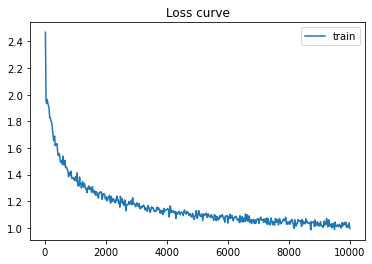

In [24]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

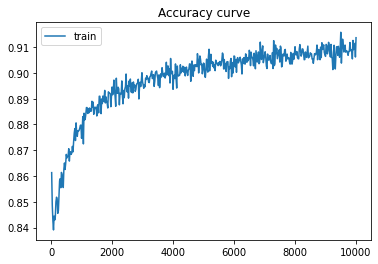

In [25]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

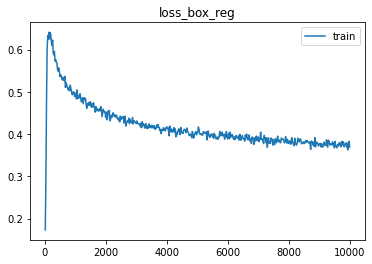

In [26]:
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["loss_box_reg"].isna()]
ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("loss_box_reg")
plt.show()

# Inference

In [27]:
# !pip install -U layoutparser 

In [28]:
import layoutparser as lp
import cv2


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (5, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (16, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (16,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (4, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) in th

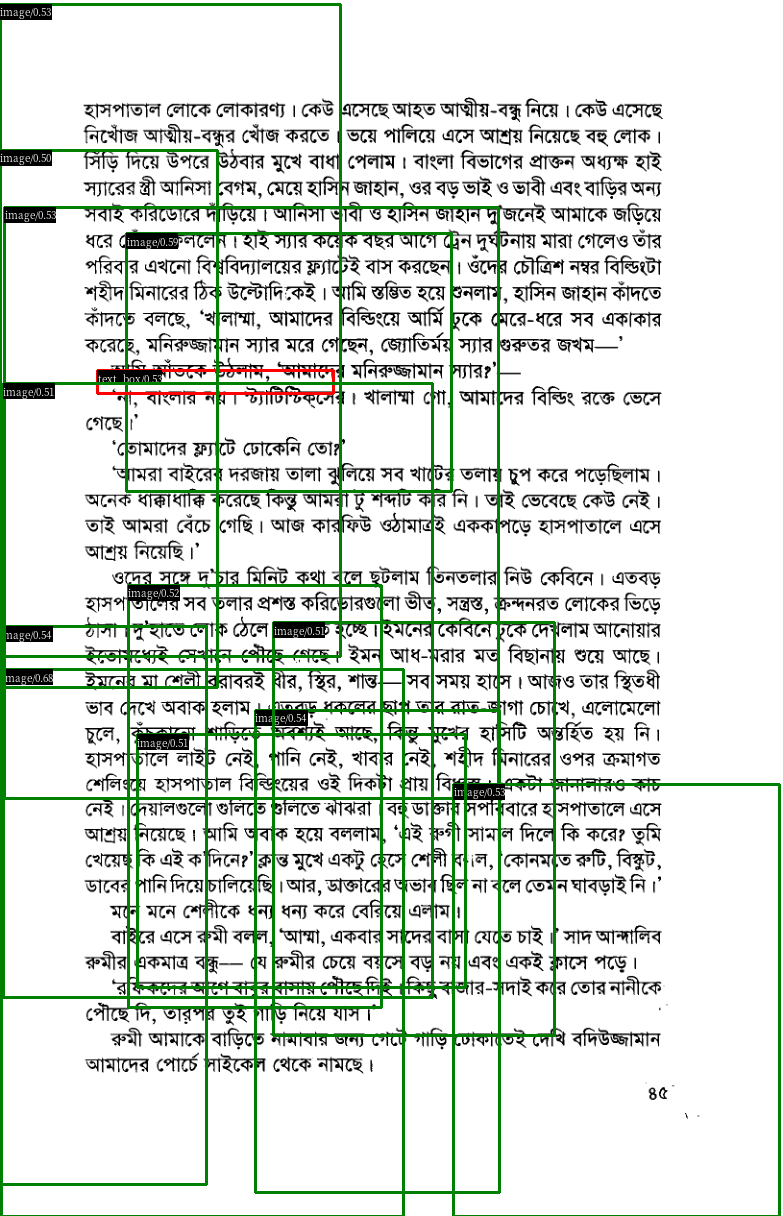

In [29]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_R_50_FPN_3x/config',
                                 './output/model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                                 label_map={0: "paragraph", 1: "text_box", 2: "image", 3:"table"})
#######################################################
image = cv2.imread('/home/ansary/Downloads/BadLad/badlad_dataset/BDLAD_01/BDLAD_Train/97ddeb35-e310-46e0-98e5-d71a1be53b5a.png')
#plt.imshow(image)
color_map = {
    'text_box':   'red',
    'paragraph':  'blue',
    'image':   'green',
    'table':  'yellow',

}

layout_predicted = model.detect(image)
lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

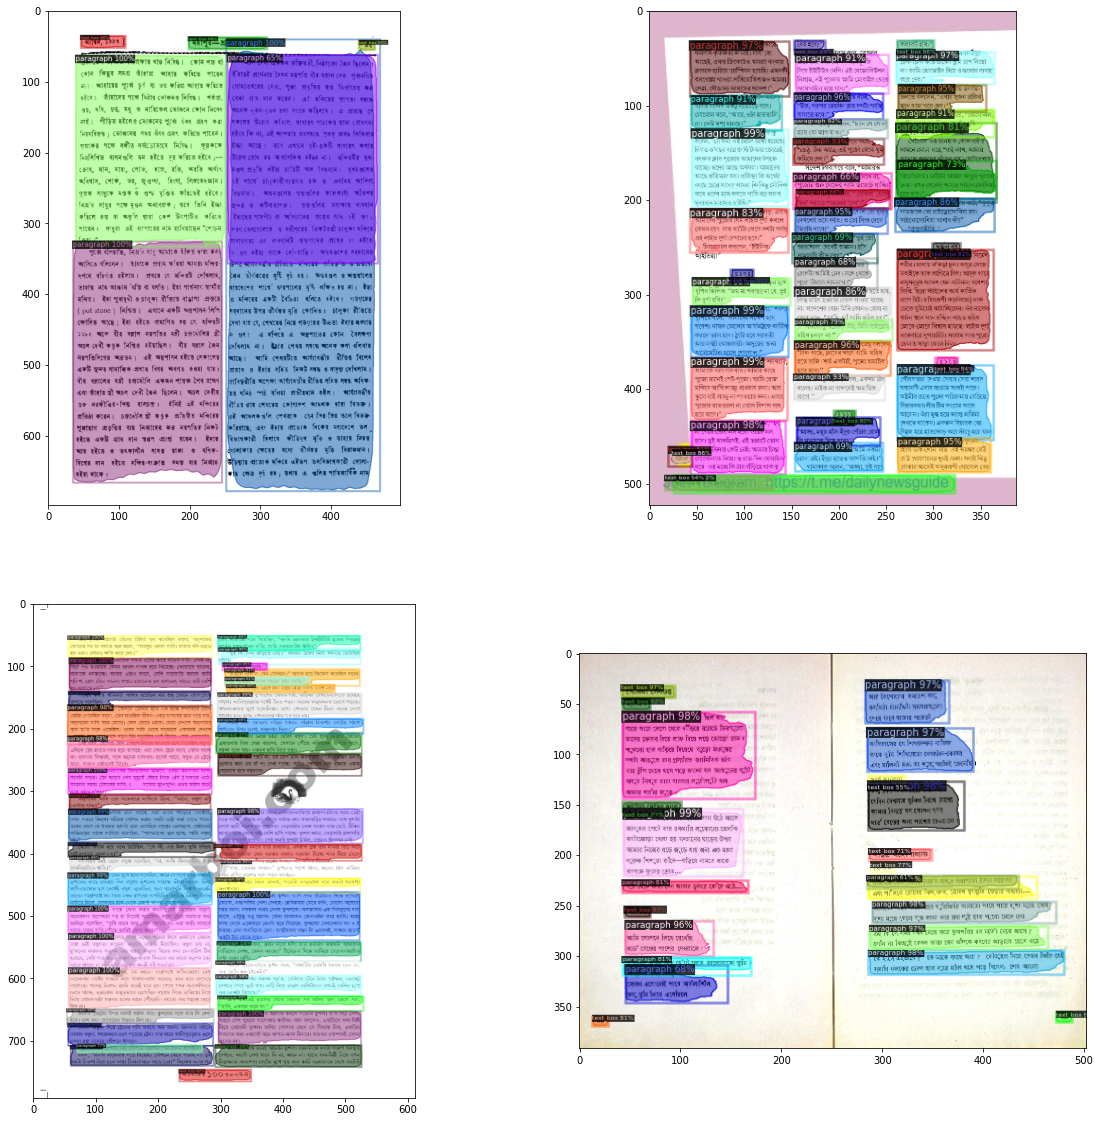

In [30]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
#cfg.DATASETS.TEST = ("Data_Resister_training", )
predictor = DefaultPredictor(cfg)

###############################################################

fig, ax = plt.subplots(2, 2, figsize =(20,20))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = random.sample(dataset_dicts_train, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_train,scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu"))
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)

In [31]:

#total epochs https://stackoverflow.com/questions/63578040/how-many-images-per-iteration-in-detectron2
cfg.SOLVER.MAX_ITER * cfg.SOLVER.IMS_PER_BATCH / len(train_meta)

23.567535719546324

In [32]:
iterations_for_one_epoch = len(train_meta) / cfg.SOLVER.IMS_PER_BATCH
iterations_for_one_epoch * 1 # == 1 epoch

424.3125

In [33]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 8
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('PL_data_valid',)
  TRAIN: ('PL_data_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'r

In [34]:
metadata_dicts_valid

namespace(name='PL_data_valid',
          thing_classes=['paragraph', 'text_box', 'image', 'table'],
          json_file='./output/PL_data_valid_coco_format.json')